# Linux Boot Tests

This notebook shows the results of linux boot tests with gem5. Five linux kernels (v4.4.186, v4.9.186, v4.14.134, v4.19.83, v5.2.3) are used in these expeirments. The booting of these kernels is tested with four cpu models (kvm, atomic, timing, O3) of gem5 alongwith two different memory systems (classic, ruby). The experiments are done with multiple core counts (1, 2, 4 and 8) and test linux boot with only init or systemd.

For details of running these tests with gem5art refer to the documentation [here](https://gem5art.readthedocs.io/en/latest/boot-tutorial.html)

In [273]:
%matplotlib notebook
import pandas as pd
import numpy as np
import sys
from matplotlib import pyplot as plt
import os

In [274]:
datadir = '/run/user/1000/gvfs/sftp:host=amarillo.cs.ucdavis.edu/fasthome/aakahlow/boot_tests/results/run_exit/'

In [275]:
Linux_Kernels = ['4.4.186', '4.9.186', '4.14.134', '4.19.83', '5.2.3']

In [276]:
# function to extract stats
def gem5GetStat(filename, stat):
    filename = os.path.join(datadir, '', filename, 'stats.txt').replace('\\','/')
    try: 
        with open(filename) as f:
            r = f.read()
            if len(r) < 10: return 0.0
            start = r.find(stat) + len(stat) + 1
            end = r.find('#', start)
            return float(r[start:end])
    except: #temporary change
        return 0.0

In [284]:
def getStatus(filename):
    out_file = os.path.join(datadir, '', filename, 'simout').replace('\\','/')
    err_file = os.path.join(datadir, '', filename, 'simerr').replace('\\','/')
    status = ''
    try: 
        with open(out_file) as f:
            l_line = f.readlines()[-1]
            if 'Running the simulation' in l_line:
                status = 'running'
            elif 'Success!' in l_line:
                status = 'success'
            else:
                status = 'failure'
    except: #temporary change
        status = 'running'

    try: 
        with open(err_file) as f:
            l_line = f.readlines()[-1]
            if '--- END LIBC BACKTRACE ---' in l_line:
                status = 'failure'
    except:
        status = 'running'    
    
    return status

In [285]:
def Debug(filename):
    filename = os.path.join(datadir, '', filename, 'simerr').replace('\\','/')
    try: 
        with open(filename) as f:
            l_line = f.readlines()[-1]
            if 'AttributeError: Class DDR3_1600_8x8 has no parameter channels' in l_line:
                return 1
            else:
                return 0
    except: #temporary change
        return 0

In [286]:
Cpus = ['kvm','atomic', 'simple', 'o3']
Mem_Systems = ['classic', 'ruby']
Cores = ['1', '2', '4', '8']
Boot_Types = ['init', 'systemd']

In [259]:
for kernel in Linux_Kernels:
    for cpu in Cpus:
        for mem_sys in Mem_Systems:
            for core in Cores:
                for boot_type in Boot_Types:                

                    file_path = 'vmlinux-{}/boot-exit/{}/{}/{}/{}/'.format(kernel,cpu,mem_sys,core,boot_type)
                    if(Debug(file_path) == 1):
                        print(file_path)


In [287]:
rows = []

for kernel in Linux_Kernels:
    for cpu in Cpus:
        for mem_sys in Mem_Systems:
            for core in Cores:
                for boot_type in Boot_Types:                

                    file_path = 'vmlinux-{}/boot-exit/{}/{}/{}/{}/'.format(kernel,cpu,mem_sys,core,boot_type)
                
                    rows.append([kernel,cpu,mem_sys,core,boot_type,
                         getStatus(file_path),        
                         gem5GetStat(file_path, 'sim_ticks')/333, #1000
                         gem5GetStat(file_path, 'sim_insts')/1000000,
                         gem5GetStat(file_path, 'sim_ops'),
                         gem5GetStat(file_path, 'sim_seconds'),
                         gem5GetStat(file_path, 'host_seconds')/60])             


df = pd.DataFrame(rows, columns=['kernel','cpu','mem_sys','core','boot_type', 'status', 'cycles', 'instructions', 'ops', 'sim_time', 'host_time'])

df['host_hours'] = df['host_time']/60
df['ipc'] = df['instructions']/df['cycles']
df['cpi'] = df['cycles']/df['instructions']
df['opc'] = df['ops']/df['cycles']
                     
#print(df)

In [288]:
#print(df[df['kernel']=='4.4.186'])

In [289]:
print(str(df['status'].iloc[100]))

running


In [292]:
def doplot_status(mem_sys,boot_type):
    plt.figure()
    i = 0
    barWidth = 1
    for kernel in Linux_Kernels:
        for cpu in Cpus:
            for j,core in enumerate(Cores):
                d = df[(df['mem_sys']==mem_sys) & (df['boot_type']==boot_type) & (df['core']==core) & (df['cpu']==cpu) & (df['kernel']==kernel)]
                if d['status'].iloc[0] == 'success':
                    plt.bar(i, 1, bottom=j, color='C'+ str(2),edgecolor='white',width=barWidth)
                if d['status'].iloc[0] == 'running':
                    plt.bar(i, 1, bottom=j, color='C'+ str(1),edgecolor='white',width=barWidth)
                if d['status'].iloc[0] == 'failure':
                    plt.bar(i, 1, bottom=j, color='C'+ str(3),edgecolor='white',width=barWidth)                                        
            i = i+1
        i = i+1
    
    colours = ['C'+ str(1), 'C'+ str(3), 'C'+ str(2)]#'R', 'Y']
    for i,cpu in enumerate(['timeout', 'failure', 'success']):
        plt.bar(0,0,color=colours[i], label=cpu)
    
    plt.xticks(list(set(np.arange(len(Linux_Kernels)*(len(Cpus)+1)))-set([4,9,14,19,24])), Cpus+Cpus+Cpus+Cpus+Cpus, rotation=90, ha='left')

## Booting Status
The next plots show the status of linux kernel booting on different configurations. Each plot shows the status for differnet possibilities of core count, cpu type and linux kernel version, but for a constant memory system (classic, ruby) and boot type (init or systemd).

<IPython.core.display.Javascript object>


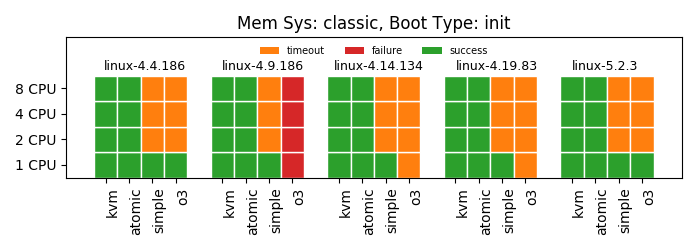

<IPython.core.display.Javascript object>


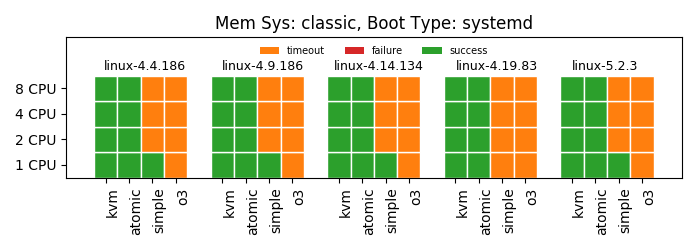

<IPython.core.display.Javascript object>


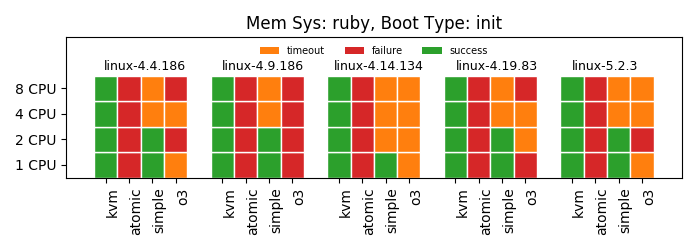

<IPython.core.display.Javascript object>


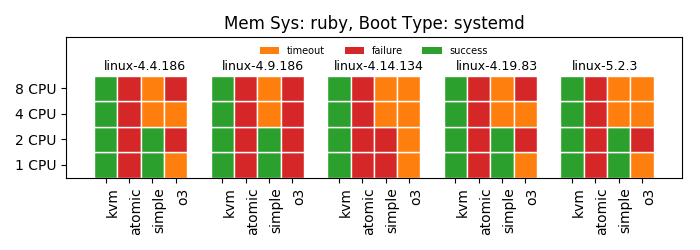

In [293]:
for mem in Mem_Systems:
    for boot_typ in Boot_Types:
        fig_size = plt.rcParams["figure.figsize"]
        fig_size[0] = 7
        fig_size[1] = 2.5
        doplot_status(mem,boot_typ)
        #plt.ylabel('Sim Time (seconds)')
        plt.yticks([0.5,1.5,2.5,3.5], ('1 CPU', '2 CPU', '4 CPU', '8 CPU'))

        plt.text(-0.1, 4.2, 'linux-{}'.format(Linux_Kernels[0]), fontsize=9)
        plt.text(5, 4.2, 'linux-{}'.format(Linux_Kernels[1]), fontsize=9)
        plt.text(9.8, 4.2, 'linux-{}'.format(Linux_Kernels[2]), fontsize=9)
        plt.text(15, 4.2, 'linux-{}'.format(Linux_Kernels[3]), fontsize=9)
        plt.text(20, 4.2, 'linux-{}'.format(Linux_Kernels[4]), fontsize=9)

        plt.ylim(ymax = 5.5, ymin = 0)
        plt.legend(loc=9, ncol=4, prop={'size': 7}, frameon=0)
        plt.title('Mem Sys: {}, Boot Type: {}'.format(mem, boot_typ))
        plt.tight_layout()

In [294]:
def doplot(mem_sys,core,boot_type,stat,norm=False):
    plt.figure()
    i = 0
    
    for kernel in Linux_Kernels:
        for j,cpu in enumerate(Cpus):
            d = df[(df['mem_sys']==mem_sys) & (df['boot_type']==boot_type) & (df['core']==core) & (df['cpu']==cpu) 
                   & (df['kernel']==kernel)]
            plt.bar(i, d[stat].iloc[0], color='C'+str(j))
            i = i+1
        i = i+1
                    
    for i,cpu in enumerate(Cpus):
        plt.bar(0,0,color='C'+str(i), label=cpu)
        
    plt.xticks(np.arange(len(Linux_Kernels))*(len(Cpus)+1)+1.5, Linux_Kernels, rotation=40, ha='right')
        

# Simulation Statistics

## Simulated Time (Seconds) 

<IPython.core.display.Javascript object>


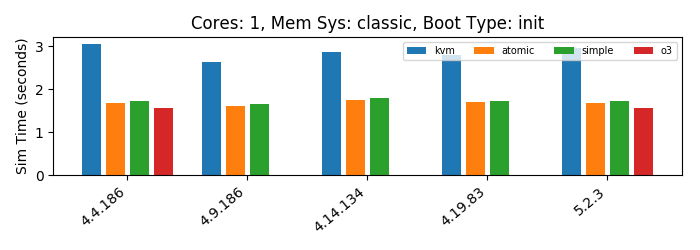

<IPython.core.display.Javascript object>


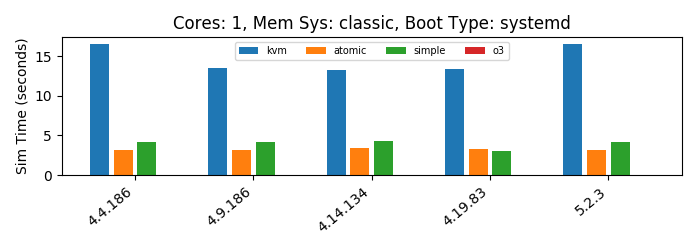

<IPython.core.display.Javascript object>


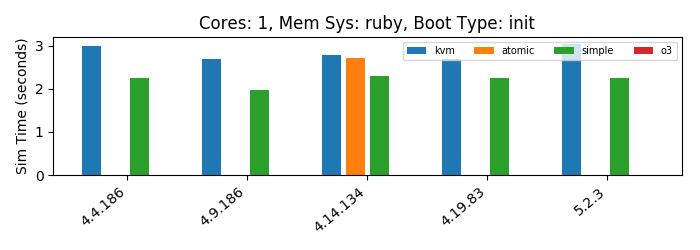

<IPython.core.display.Javascript object>


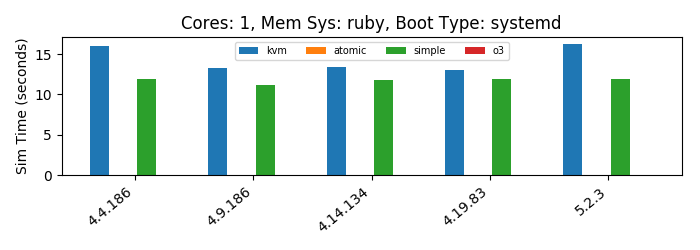

<IPython.core.display.Javascript object>


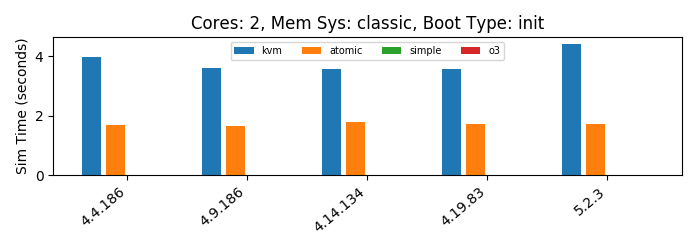

<IPython.core.display.Javascript object>


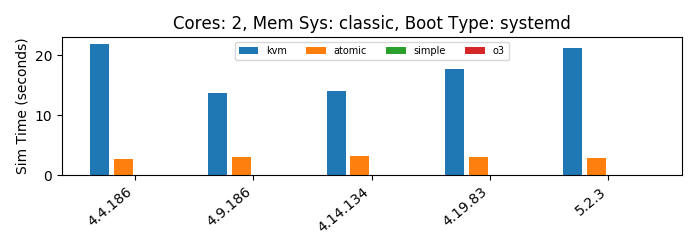

<IPython.core.display.Javascript object>


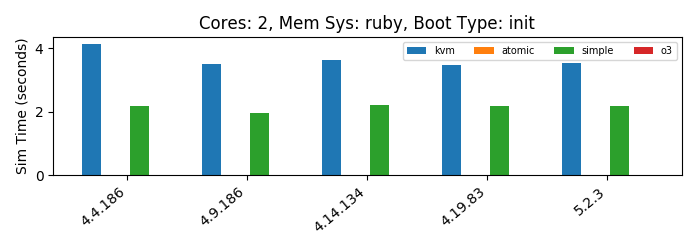

<IPython.core.display.Javascript object>


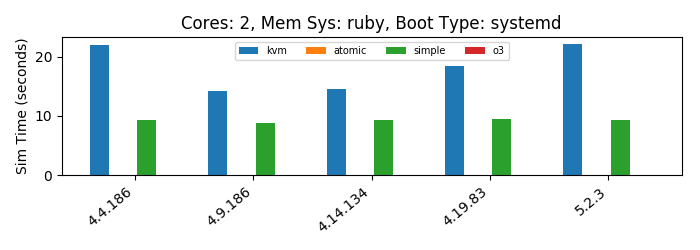

<IPython.core.display.Javascript object>


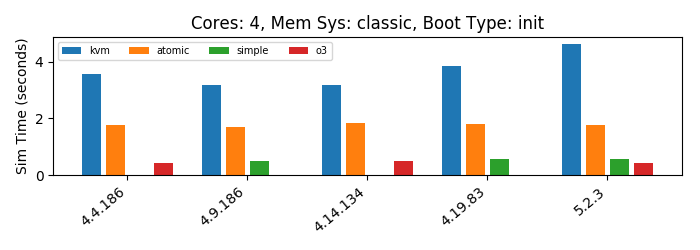

<IPython.core.display.Javascript object>


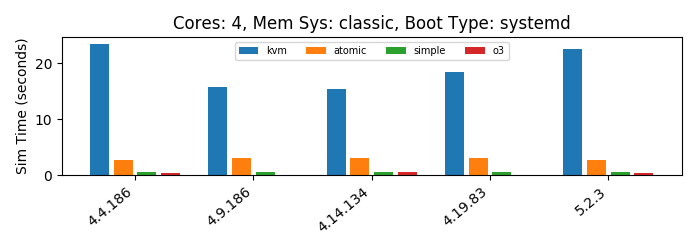

<IPython.core.display.Javascript object>


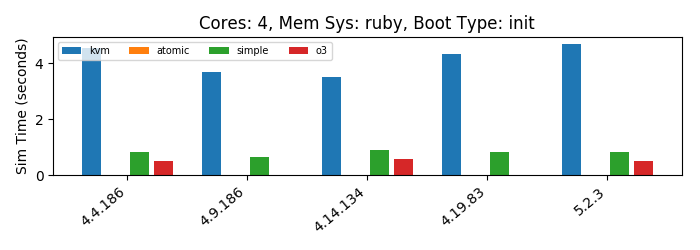

<IPython.core.display.Javascript object>


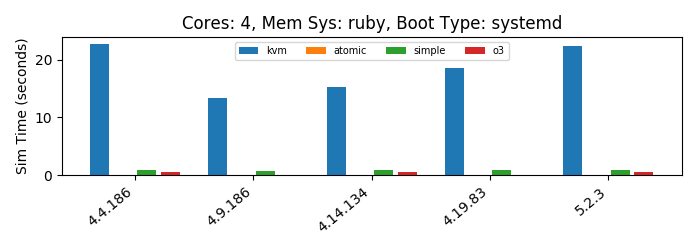

<IPython.core.display.Javascript object>


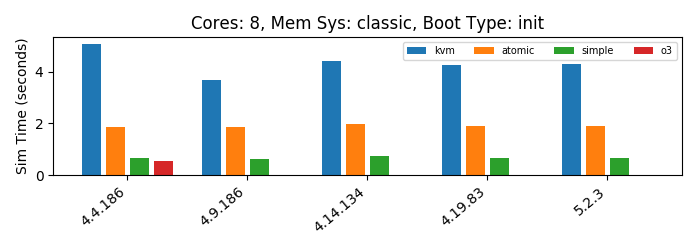

<IPython.core.display.Javascript object>


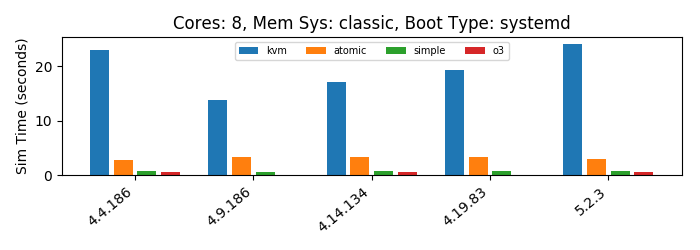

<IPython.core.display.Javascript object>


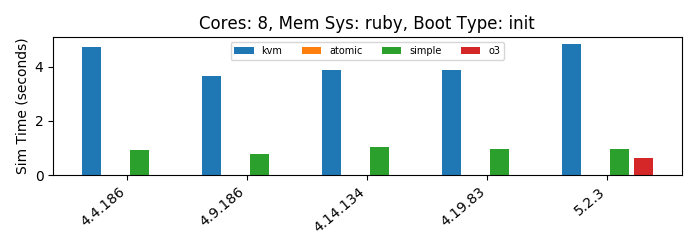

<IPython.core.display.Javascript object>


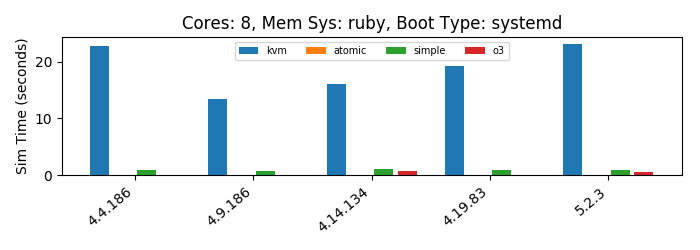

In [295]:
#plt.rcParams["figure.figsize"] = fig_size

Cores = ['1', '2', '4', '8']
Boot_Types = ['init', 'systemd']

for core_cn in ['1', '2', '4', '8']:
    for mem in ['classic', 'ruby']:
        for boot_typ in ['init', 'systemd']:
            fig_size = plt.rcParams["figure.figsize"]
            fig_size[0] = 7
            fig_size[1] = 2.5
            doplot(mem,core_cn,boot_typ,'sim_time')
            plt.ylabel('Sim Time (seconds)')
            #plt.ylim(ymax = 10, ymin = 0)
            plt.legend(loc=0, ncol=4, prop={'size': 7})
            plt.title('Cores: {}, Mem Sys: {}, Boot Type: {}'.format(core_cn, mem, boot_typ))
            plt.tight_layout()


## Number of Instructions (in millions)

<IPython.core.display.Javascript object>


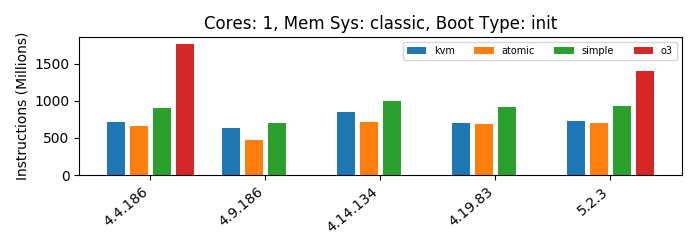

<IPython.core.display.Javascript object>


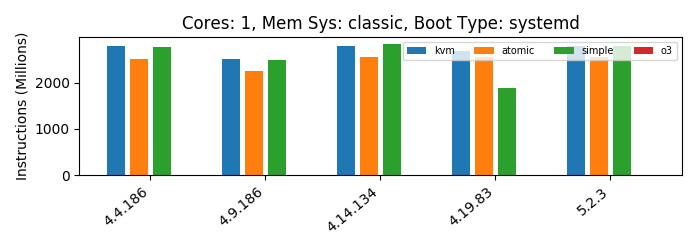

<IPython.core.display.Javascript object>


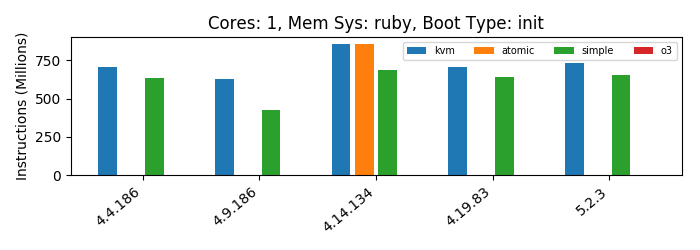

<IPython.core.display.Javascript object>


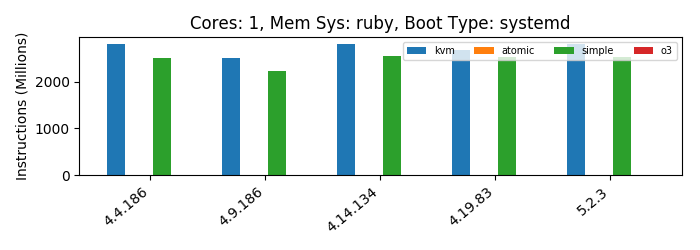

<IPython.core.display.Javascript object>


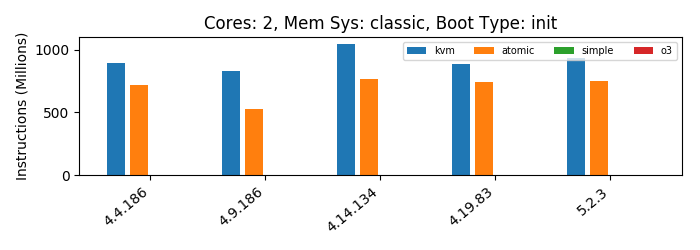

<IPython.core.display.Javascript object>


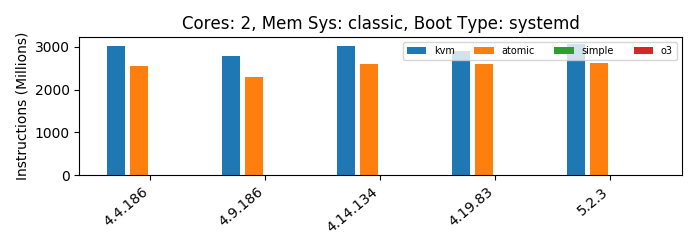

<IPython.core.display.Javascript object>


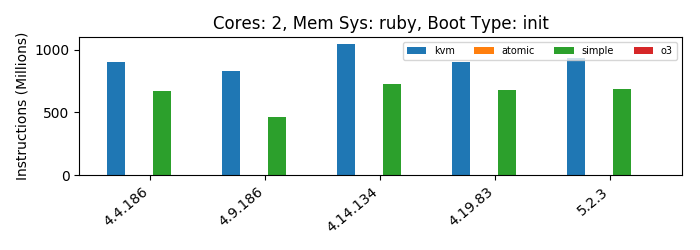

<IPython.core.display.Javascript object>


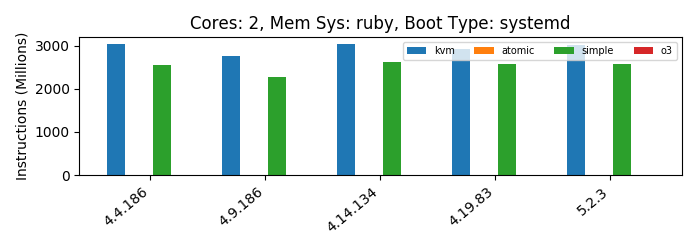

<IPython.core.display.Javascript object>


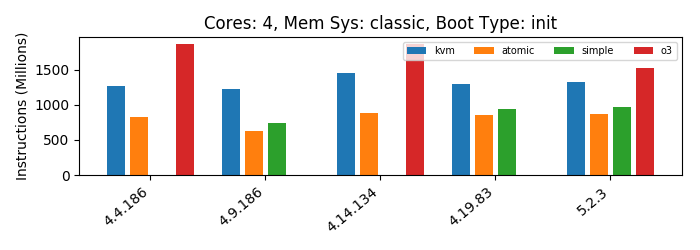

<IPython.core.display.Javascript object>


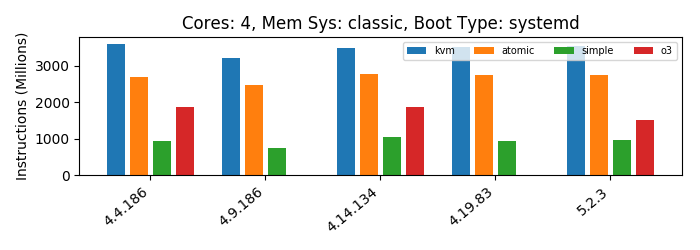

<IPython.core.display.Javascript object>


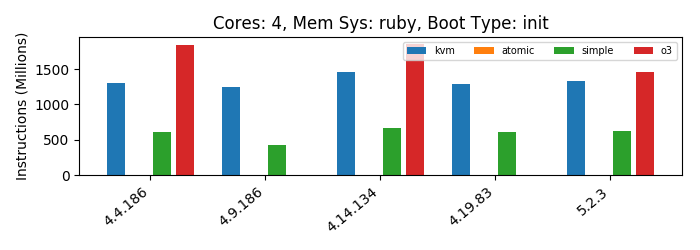

<IPython.core.display.Javascript object>


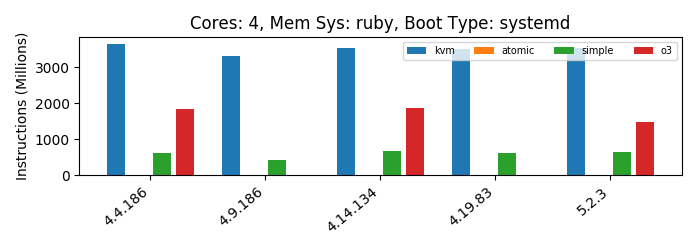

<IPython.core.display.Javascript object>


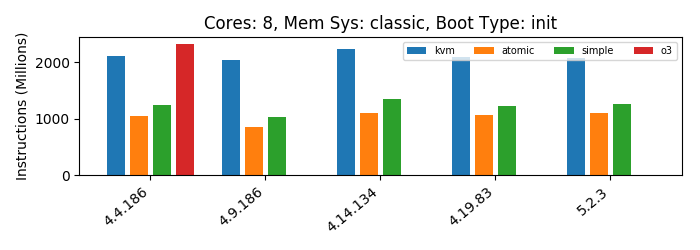

<IPython.core.display.Javascript object>


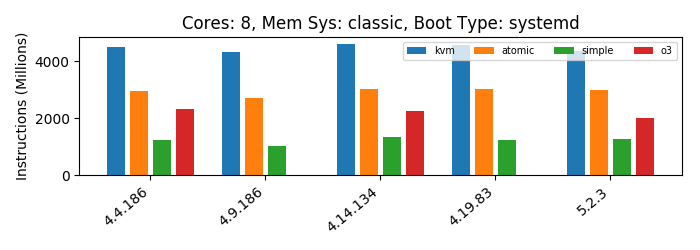

<IPython.core.display.Javascript object>


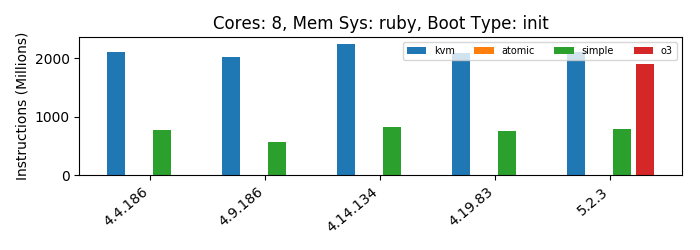

<IPython.core.display.Javascript object>


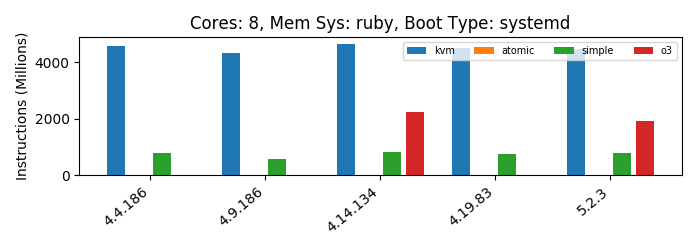

In [296]:
#plt.rcParams["figure.figsize"] = fig_size

Cores = ['1', '2', '4', '8']
Boot_Types = ['init', 'systemd']

for core_cn in ['1', '2', '4', '8']:
    for mem in ['classic', 'ruby']:
        for boot_typ in ['init', 'systemd']:
            fig_size = plt.rcParams["figure.figsize"]
            fig_size[0] = 7
            fig_size[1] = 2.5
            doplot(mem,core_cn,boot_typ,'instructions')
            plt.ylabel('Instructions (Millions)')
            #plt.ylim(ymax = 100, ymin = 0)
            plt.legend(loc=0, ncol=4, prop={'size': 7})
            plt.title('Cores: {}, Mem Sys: {}, Boot Type: {}'.format(core_cn, mem, boot_typ))
            plt.tight_layout()

## Host Time (minutes)

<IPython.core.display.Javascript object>


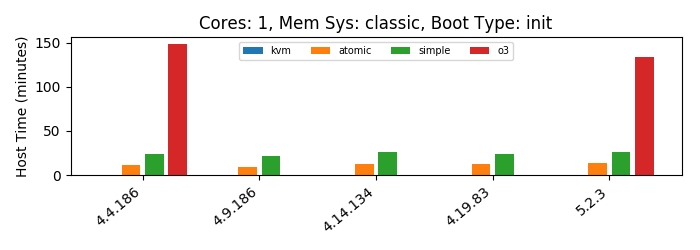

<IPython.core.display.Javascript object>


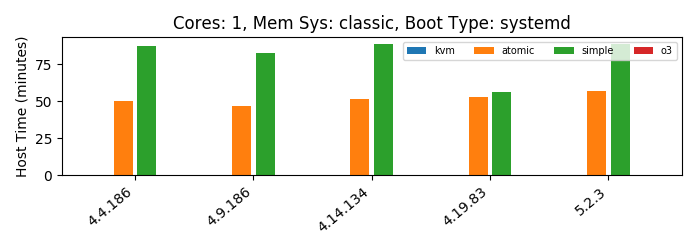

<IPython.core.display.Javascript object>


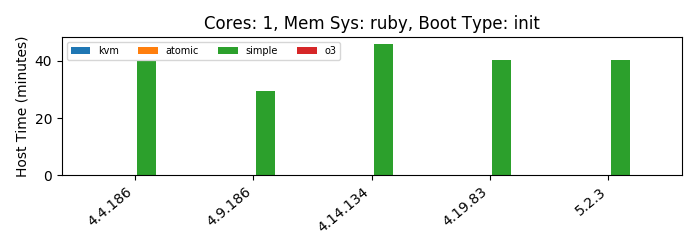

<IPython.core.display.Javascript object>


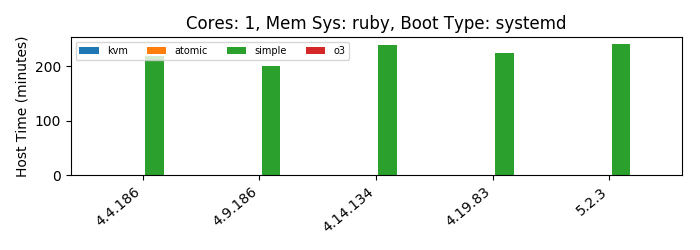

<IPython.core.display.Javascript object>


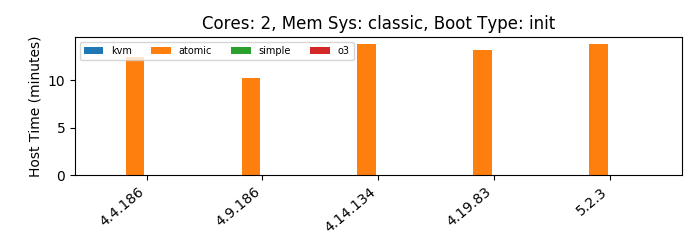

<IPython.core.display.Javascript object>


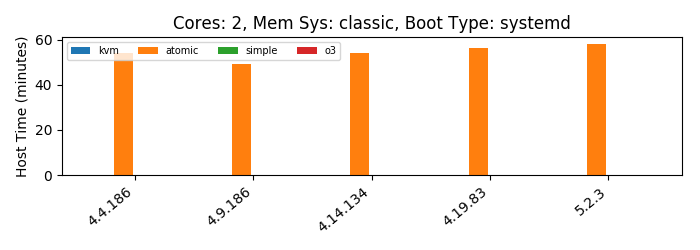

<IPython.core.display.Javascript object>


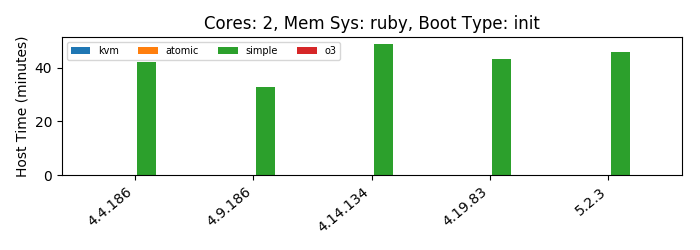

<IPython.core.display.Javascript object>


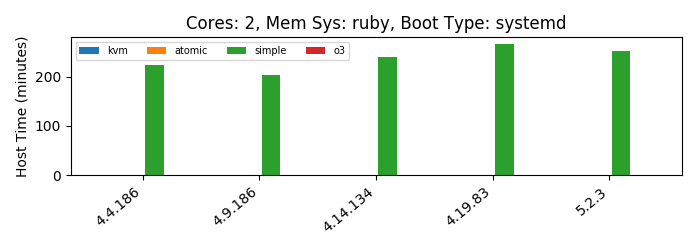

<IPython.core.display.Javascript object>


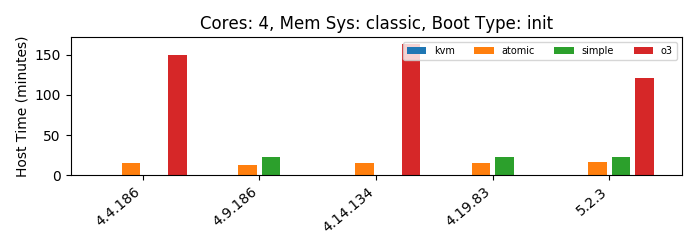

<IPython.core.display.Javascript object>


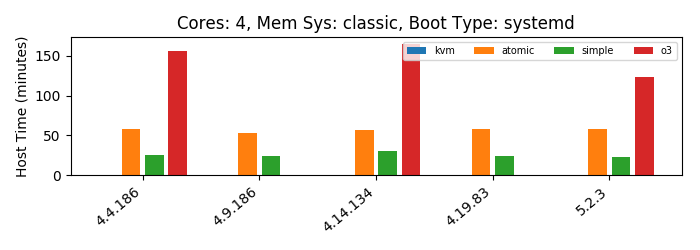

<IPython.core.display.Javascript object>


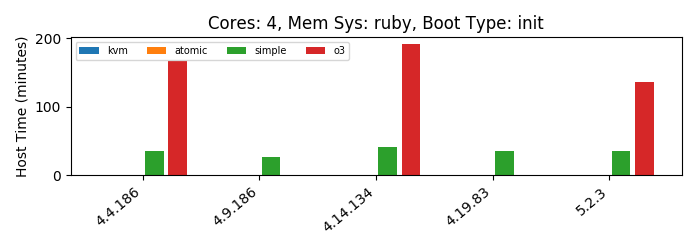

<IPython.core.display.Javascript object>


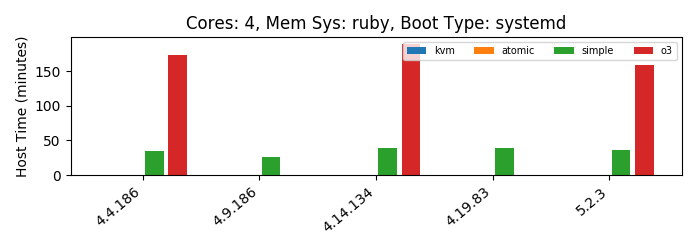

<IPython.core.display.Javascript object>


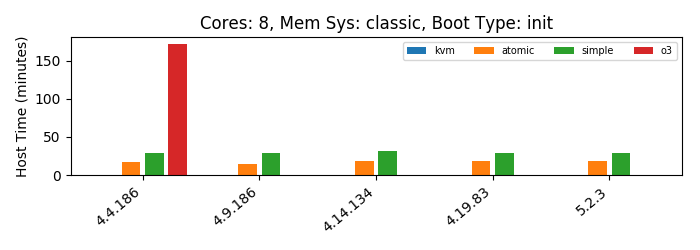

<IPython.core.display.Javascript object>


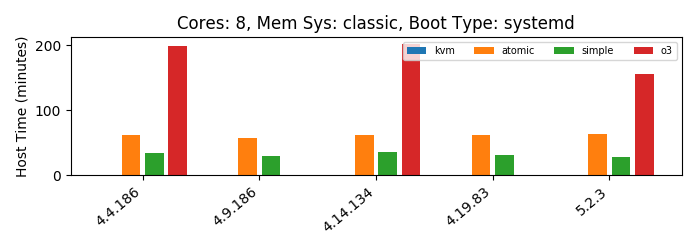

<IPython.core.display.Javascript object>


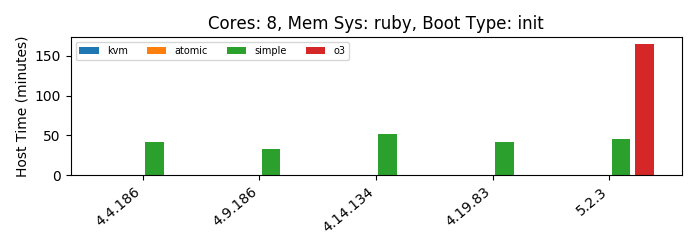

<IPython.core.display.Javascript object>


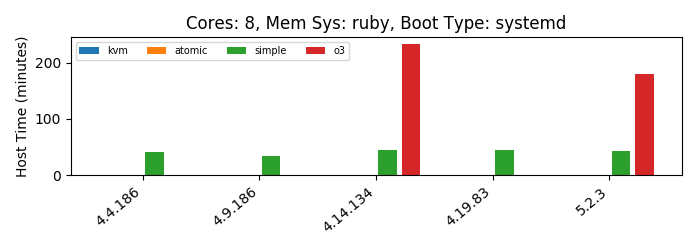

In [297]:
#plt.rcParams["figure.figsize"] = fig_size

Cores = ['1', '2', '4', '8']
Boot_Types = ['init', 'systemd']

for core_cn in ['1', '2', '4', '8']:
    for mem in ['classic', 'ruby']:
        for boot_typ in ['init', 'systemd']:
            fig_size = plt.rcParams["figure.figsize"]
            fig_size[0] = 7
            fig_size[1] = 2.5
            doplot(mem,core_cn,boot_typ,'host_time')
            plt.ylabel('Host Time (minutes)')
            #plt.ylim(ymax = 100, ymin = 0)
            plt.legend(loc=0, ncol=4, prop={'size': 7})
            plt.title('Cores: {}, Mem Sys: {}, Boot Type: {}'.format(core_cn, mem, boot_typ))
            plt.tight_layout()
